# **Project Chatbot Customer Support on Twitter**
---

## **Goal** 

Developing a chatbot capable of providing automated responses to customer reviews based on the sentiment of the review text.

## **Columns**

| Columns        | Description                                                                                                      |
| ------------ | -------------------------------------------------------------------------------------------------------------- |
| `tweet_id`     | The unique ID for this tweet                                                                                 |
| `author_id`        | The unique ID for this tweet author (anonymized for non-company users)                                                             |
| `inbound`        | Whether or not the tweet was sent (inbound) to a company                                                                                       |
| `created_at`    | When the tweet was created                                                              |
| `text`    | The text content of the tweet                                                                         |
| `response_tweet_id`    | The tweet that responded to this one, if any                                                          |
| `in_response_to_tweet_id`       | The tweet this tweet was in response to, if any

---


### **1. Data Collection**

In [ ]:
# 1. IMPORT & DOWNLOAD LIBRARIES AND PACKAGES

import pandas as pd
import numpy as np
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import streamlit as st

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')


# 2. LOAD DATASET

Reviews = pd.read_csv("sample.csv")
Reviews = Reviews.rename(columns={col:col.strip() for col in Reviews.columns})  
print(f"Shape: {Reviews.shape}")
Reviews.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...


Shape: (93, 7)


[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,119237,105834,True,Wed Oct 11 06:55:44 +0000 2017,@AppleSupport causing the reply to be disregar...,119236,NaN
1,119238,ChaseSupport,False,Wed Oct 11 13:25:49 +0000 2017,@105835 Your business means a lot to us. Pleas...,NaN,119239.0
2,119239,105835,True,Wed Oct 11 13:00:09 +0000 2017,@76328 I really hope you all change but I'm su...,119238,NaN
3,119240,VirginTrains,False,Tue Oct 10 15:16:08 +0000 2017,@105836 LiveChat is online at the moment - htt...,119241,119242.0
4,119241,105836,True,Tue Oct 10 15:17:21 +0000 2017,@VirginTrains see attached error message. I've...,119243,119240.0


#### **2. Data Cleaning**

In [2]:
# 3. DATA CLEANING

print(Reviews.isnull().sum())

# Handle missing values by replacing them with ‘None’
Reviews["response_tweet_id"].fillna("None", inplace=True)
Reviews["in_response_to_tweet_id"].fillna("None", inplace=True)

tweet_id                    0
author_id                   0
inbound                     0
created_at                  0
text                        0
response_tweet_id          28
in_response_to_tweet_id    25
dtype: int64


C:\Users\USER\AppData\Local\Temp\ipykernel_18340\3716829075.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Reviews["response_tweet_id"].fillna("None", inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_18340\3716829075.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



#### **3. Exploratory Data Analysis**

In [14]:
Reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   tweet_id                 93 non-null     int64              
 1   author_id                93 non-null     object             
 2   inbound                  93 non-null     bool               
 3   created_at               93 non-null     datetime64[ns, UTC]
 4   text                     93 non-null     object             
 5   response_tweet_id        93 non-null     object             
 6   in_response_to_tweet_id  93 non-null     object             
 7   text_length              93 non-null     int64              
 8   date                     93 non-null     object             
 9   clean_text               93 non-null     object             
 10  sentiment_score          93 non-null     float64            
 11  sentiment                93 non-nu

In [15]:
Reviews.describe()

,tweet_id,text_length,sentiment_score
count,93.000000,93.000000,93.000000
mean,119285.451613,118.483871,0.232781
std,28.314045,33.691249,0.445479
min,119237.000000,32.000000,-0.875000
25%,119262.000000,93.000000,0.000000
50%,119285.000000,132.000000,0.296000
75%,119309.000000,146.000000,0.636900
max,119335.000000,170.000000,0.880700


C:\Users\USER\AppData\Local\Temp\ipykernel_18340\2079278905.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Reviews["created_at"] = pd.to_datetime(Reviews["created_at"], errors="coerce")


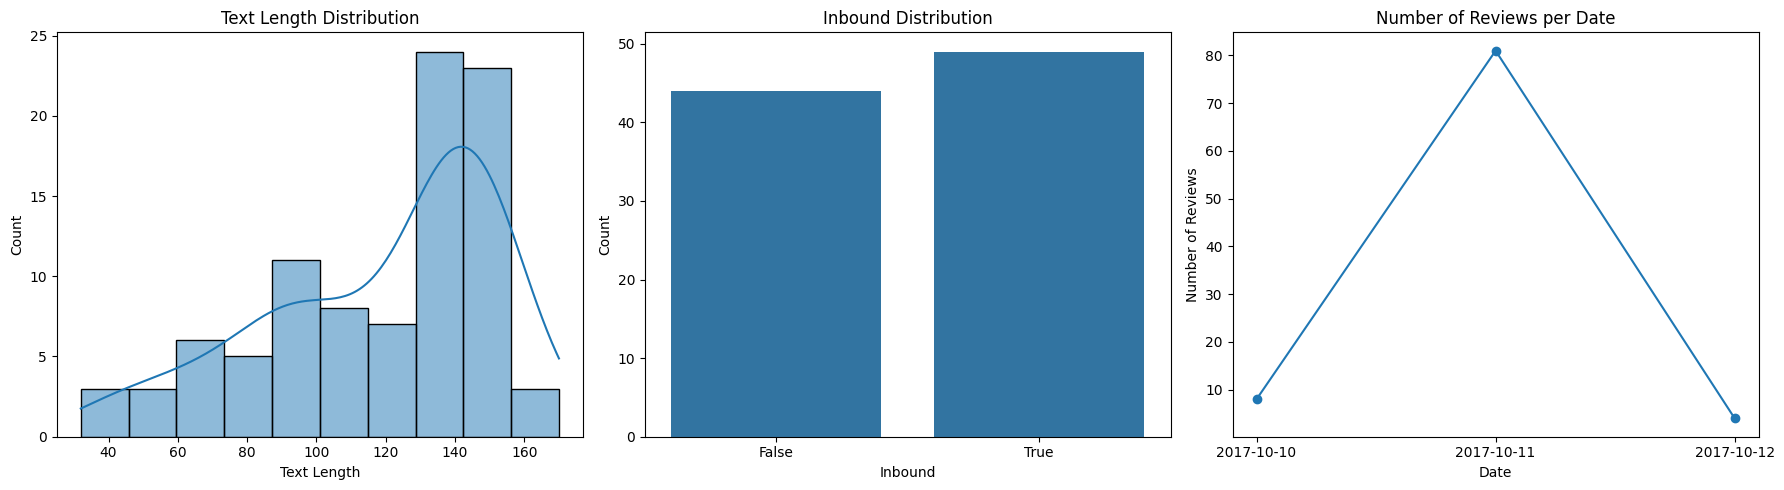

In [ ]:
# 4. EXPLORATORY DATA ANALYSIS 

# 1. Text Length Distribution
Reviews["text_length"] = Reviews["text"].apply(len)

# 2. Convert created_at to datetime & extract date
Reviews["created_at"] = pd.to_datetime(Reviews["created_at"], errors="coerce")
Reviews["date"] = Reviews["created_at"].dt.strftime("%Y-%m-%d")
date = Reviews["date"].value_counts().sort_index()

# Creating a diagram with 3 parallel subplots
plt.figure(figsize=(18, 5))

# a. Text Length Distribution 
plt.subplot(1, 3, 1)
sns.histplot(data=Reviews, x="text_length", bins=10, kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Count")

# b. Inbound Distribution 
plt.subplot(1, 3, 2)
sns.countplot(x="inbound", data=Reviews)
plt.title("Inbound Distribution")
plt.xlabel("Inbound")
plt.ylabel("Count")

# c. Number of Reviews per Date
plt.subplot(1, 3, 3)
plt.plot(date.index, date.values, marker='o')
plt.title("Number of Reviews per Date")
plt.xlabel("Date")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### **4. Preprocessing Functions**

In [4]:
# 5. PREPROCESSING FUNCTIONS

stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+|@\w+|#|[^a-z\s]', ' ', text)
    tokenss = nltk.word_tokenize(text)
    tokenss = [lemmatizer.lemmatize(token) for token in tokenss if token not in stop and len(token) > 1]
    return " ".join(tokenss)

Reviews['clean_text'] = Reviews['text'].apply(clean_text)
Reviews[['text','clean_text']].head()

sia = SentimentIntensityAnalyzer()
Reviews["sentiment_score"] = Reviews["clean_text"].apply(lambda x: sia.polarity_scores(x)["compound"])

# Converting scores into labels
def get_label(score):
    if score > 0.05:
        return "positive"
    elif score < -0.05:
        return "negative"
    else:
        return "neutral"
Reviews["sentiment"] = Reviews["sentiment_score"].apply(get_label)

#### **5. Data Splitting**

In [5]:
# 6. DATA SPLITTING

X = Reviews["clean_text"]
y = Reviews["sentiment"] 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

**How VADER Works**

- "I love this product!" → compound = 0.8 → positive

- "This is bad." → compound = -0.6 → negative

#### **6. Build TF-IDF & Classifier Pipelines**

In [6]:
# 7. BUILD TF-IDF + CLASSIFIER PIPELINES 

pipelines = {  
    'MultinomialNB': Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=20000)),
        ('clf', MultinomialNB())
    ]),
    'LogisticRegression': Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=20000)),
        ('clf', LogisticRegression(max_iter=1000))
    ]),
    'RandomForest': Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=10000)),
        ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
    ])
}

#### **7. Training & Evaluation Model**

Training MultinomialNB
MultinomialNB accuracy: 0.631578947368421
              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000         4
     neutral     0.0000    0.0000    0.0000         3
    positive     0.6316    1.0000    0.7742        12

    accuracy                         0.6316        19
   macro avg     0.2105    0.3333    0.2581        19
weighted avg     0.3989    0.6316    0.4890        19



c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

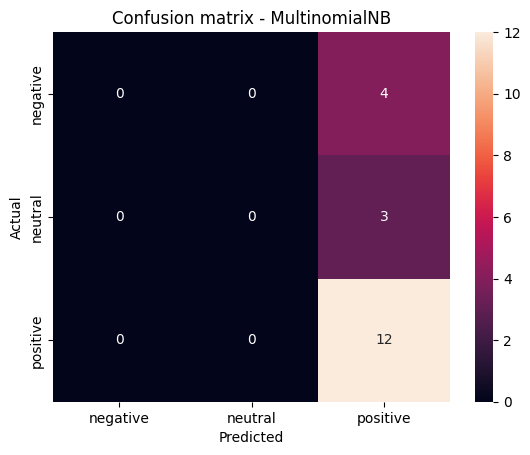

Training LogisticRegression
LogisticRegression accuracy: 0.631578947368421
              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000         4
     neutral     0.0000    0.0000    0.0000         3
    positive     0.6316    1.0000    0.7742        12

    accuracy                         0.6316        19
   macro avg     0.2105    0.3333    0.2581        19
weighted avg     0.3989    0.6316    0.4890        19



c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

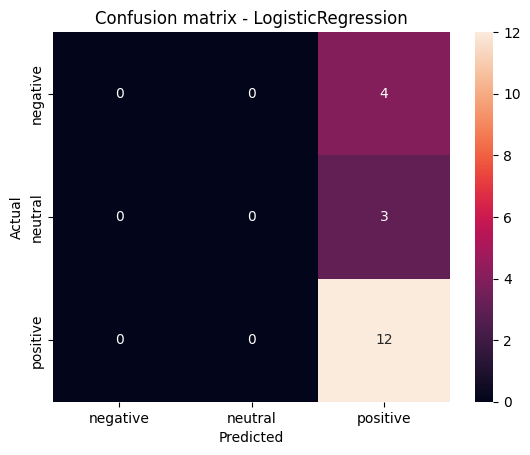

Training RandomForest
RandomForest accuracy: 0.631578947368421
              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000         4
     neutral     0.0000    0.0000    0.0000         3
    positive     0.6316    1.0000    0.7742        12

    accuracy                         0.6316        19
   macro avg     0.2105    0.3333    0.2581        19
weighted avg     0.3989    0.6316    0.4890        19



c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

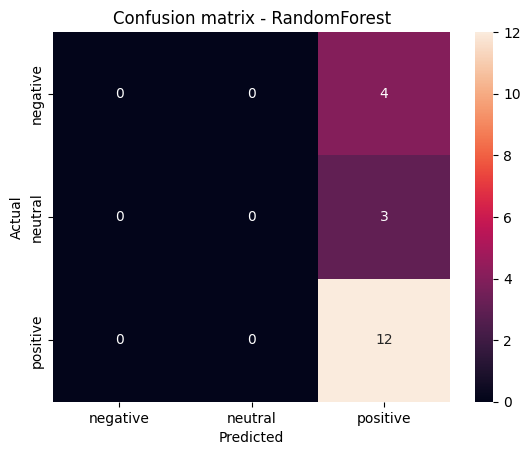

In [7]:
# 8. TRAIN & EVALUATE

results = {}
for name, pipe in pipelines.items():
    print("Training", name)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(name, "accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred, labels=['negative','neutral','positive'])
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['negative','neutral','positive'], yticklabels=['negative','neutral','positive'])
    plt.title(f"Confusion matrix - {name}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()
    results[name] = {'model': pipe, 'y_pred': y_pred}

### **Model Evaluation Results**

| Model                  | Accuracy   | Precision (macro) | Recall (macro) | F1-score (macro) |
| ---------------------- | ---------- | ----------------- | -------------- | ---------------- |
| **MultinomialNB**      | 0.6315     | 0.2105            | 0.3333         | 0.2581           |
| **LogisticRegression** | 0.6315     | 0.2105            | 0.3333         | 0.2581       |
| **RandomForest**       | 0.6315     | 0.2105            | 0.3333         | 0.2581           |

#### **Note:**

All models produce the same results due to the small dataset and unbalanced sentiment

#### **8. Save Model in Joblib**

In [8]:
# 9. SAVE BEST MODEL (joblib)

best = pipelines['LogisticRegression']   
joblib.dump(best, "ReviewSentiment.joblib")
print("Saved model to ReviewSentiment.joblib")

Saved model to ReviewSentiment.joblib


---

### **Chatbot Using VADER Sentiment Analysis**

VADER (Valence Aware Dictionary and Sentiment Reasoner) is a NLTK tool specifically for text sentiment analysis.

In this section, VADER is applied to improve sentiment detection accuracy. Unlike Logistic Regression, which depends on trained data, VADER uses predefined sentiment rules that work well with informal and chat-like language.

#### **Load Dataset**

In [9]:
df = pd.read_csv("sample.csv")
df.columns = [col.strip() for col in df.columns]

#### **Preprocessing Function**

In [10]:
# 2. PREPROCESSING

sia = SentimentIntensityAnalyzer()
stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www.\S+|@\w+|#|[^a-z\s]', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop and len(token) > 1]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(clean_text)
print(df[['clean_text']].head())

                                          clean_text
0  causing reply disregarded tapped notification ...
1  business mean lot u please dm name zip code ad...
2                            really hope change sure
3  livechat online moment contact option leave me...
4  see attached error message tried leaving voice...


#### **NLP Functions**

In [11]:
# 3. CHATBOT FUNCTION

sia = SentimentIntensityAnalyzer()
responses = {
    "greeting": "Hello! How can I help you today? 😊",
    "positive": "Thank you for your positive feedback! We're glad you enjoyed it 😄",
    "negative": "We're sorry to hear about your experience 😢",
    "neutral": "Thank you for your feedback. We'll keep improving our service.",
    "goodbye": "Goodbye! Have a nice day 👋"
}

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)  
    text = re.sub(r"[^a-zA-Z\s]", "", text)     
    text = re.sub(r"\s+", " ", text).strip()    
    return text

def chatbot_response(text):
    clean_text = preprocess_text(text)   
    greetings = ["hello", "hallo", "halo", "haloo", "hai", "hi", "hei", "heyy", "hey", "good morning", "morning", "good afternoon", "good evening", "help", "help me", "i need help", "need help"]
    farewells = ["bye", "goodbye", "see you", "thanks", "thank you"]
    if any(greet in clean_text for greet in greetings):
        return responses["greeting"]
    elif any(farewell in clean_text for farewell in farewells):
        return responses["goodbye"]
    
    score = sia.polarity_scores(clean_text)['compound']    
    if score > 0.05:
        return responses["positive"]
    elif score < -0.05:
        return responses["negative"]
    else:
        return responses["neutral"]

#### **Chatbot Deployment**

In [ ]:
# 4. RUN CHATBOT

# Directly Attempting to Input a Review
print("🤖 Helpdesk Chatbot ready! Type 'exit' to quit.")
while True:
    user_input = input("You: ")
    if user_input.lower() == "exit":
        print("Chatbot: See ya! 👋")
        break
    print("Chatbot:", chatbot_response(user_input))

🤖 Helpdesk Chatbot ready! Type 'exit' to quit.
Chatbot: See ya! 👋


#### **Streamlit / Demo Chatbot for Customer Feedback Analysis using VADER Sentiment Analysis**

In [13]:
st.title("💬 Chatbot Customer Support")
st.write("A simple sentiment-based chatbot using **VADER Sentiment Analyzer**")

user_input = st.text_input("Type your message here:")

if user_input:
    response = chatbot_response(user_input)
    st.markdown(f"**Chatbot:** {response}")

2025-11-11 13:55:05.504 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 13:55:09.502 
  command:

    streamlit run C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-11-11 13:55:09.504 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 13:55:09.505 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 13:55:09.511 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 13:55:09.520 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 13:55:09.522 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 13:55:09.533 Threa

##### **How to Run?**

1. Open your terminal (Ctrl + `) and type: "streamlit run app.py"

2. Enter a review in the input box. The app will display whether the review is classified as positive or negative.

---

## **Insight**

- Model Evaluation, the Logistic Regression model produced inconsistent sentiment predictions due to the limited dataset size, which caused the model to underperform when applied to real conversational inputs.

- Model Enhancement with VADER, to overcome this limitation, the VADER Sentiment Analyzer was implemented. VADER is more effective in analyzing conversational or social media–style text and does not require a labeled dataset to deliver reliable sentiment predictions.

- Technical Aspect, the combination of lexicon-based sentiment analysis (VADER) and rule-based intent detection enhances the chatbot’s flexibility while reducing its dependency on large-scale training data.

- Business Value, this chatbot can serve as a first-line customer support tool capable of automatically capturing user sentiment. Positive feedback can be utilized as testimonials, while negative feedback can be flagged for follow-up. This approach ultimately contributes to improved customer satisfaction and operational efficiency.